In [1]:
pip install tensorflow opencv-python-headless numpy pandas matplotlib seaborn


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV для работы с изображениями
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Путь к директории с датасетом
dataset_path = "/content/drive/My Drive/Birds_Dataset"

In [5]:
# Проверяем структуру данных
def analyze_dataset_structure(path: str) -> None:
    """
    Функция для проверки структуры датасета.

    :param path: Путь к корневой директории датасета
    """
    for folder in ['train', 'test', 'valid']:
        folder_path = os.path.join(path, folder)
        print(f"\nСодержимое папки {folder}:")
        for species in os.listdir(folder_path):
            species_path = os.path.join(folder_path, species)
            if os.path.isdir(species_path):
                print(f"- {species}: {len(os.listdir(species_path))} изображений")

# Анализируем структуру датасета
analyze_dataset_structure(dataset_path)


Содержимое папки train:
- AFRICAN EMERALD CUCKOO: 154 изображений
- AMERICAN COOT: 158 изображений
- AFRICAN PYGMY GOOSE: 179 изображений
- ABBOTTS BABBLER: 166 изображений
- ALBERTS TOWHEE: 161 изображений
- ALTAMIRA YELLOWTHROAT: 150 изображений
- AFRICAN OYSTER CATCHER: 155 изображений
- ALPINE CHOUGH: 166 изображений
- AFRICAN PIED HORNBILL: 187 изображений
- AMERICAN KESTREL: 155 изображений
- AMERICAN AVOCET: 179 изображений
- AMERICAN FLAMINGO: 164 изображений
- AMERICAN GOLDFINCH: 133 изображений
- AFRICAN CROWNED CRANE: 137 изображений
- AMERICAN BITTERN: 170 изображений
- ABYSSINIAN GROUND HORNBILL: 179 изображений
- AFRICAN FIREFINCH: 137 изображений
- ABBOTTS BOOBY: 180 изображений
- ALBATROSS: 133 изображений
- ALEXANDRINE PARAKEET: 165 изображений

Содержимое папки test:
- AFRICAN EMERALD CUCKOO: 5 изображений
- AMERICAN COOT: 5 изображений
- ALBERTS TOWHEE: 5 изображений
- AFRICAN PYGMY GOOSE: 5 изображений
- ABBOTTS BABBLER: 5 изображений
- ALTAMIRA YELLOWTHROAT: 5 изо

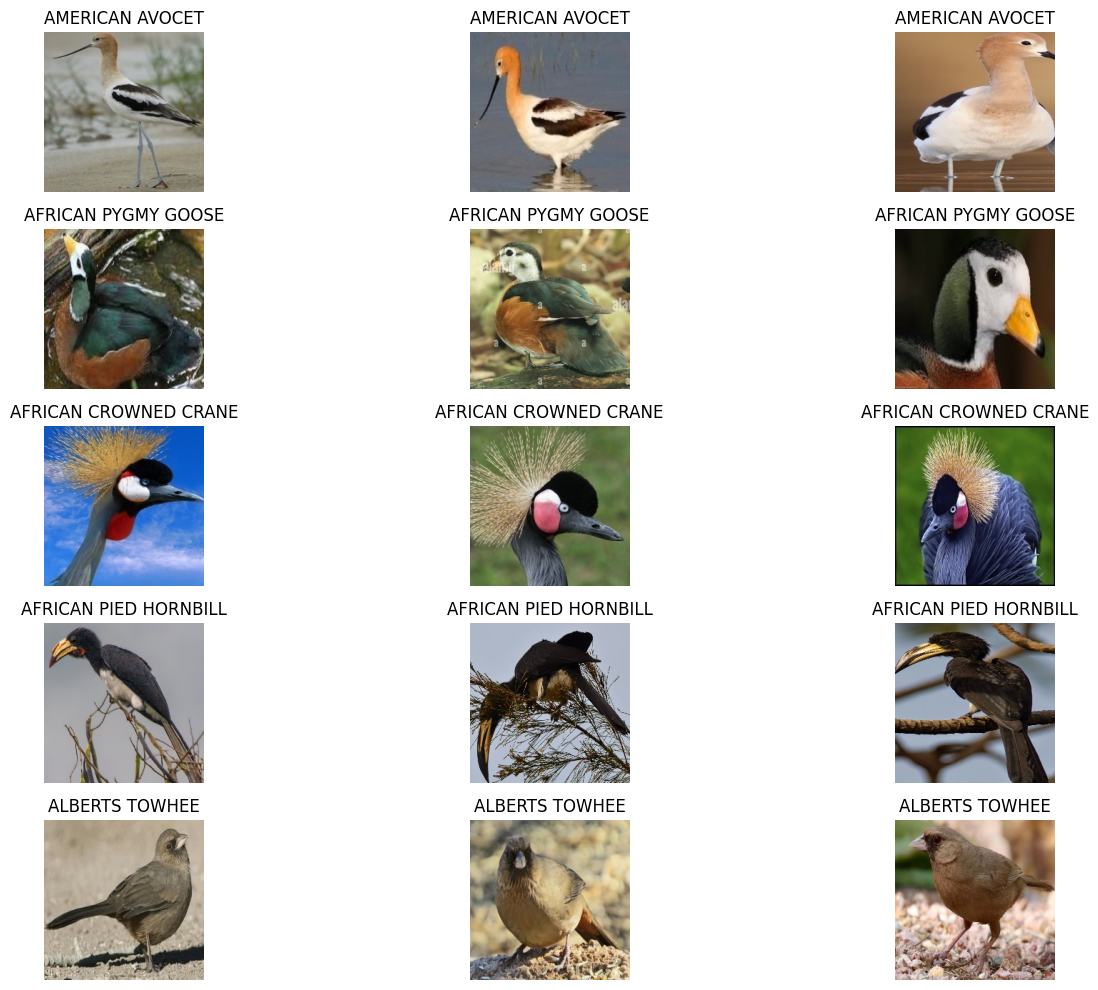

In [6]:
# Визуализация примеров изображений
def visualize_sample_images(path: str, folder: str = 'valid', samples_per_species: int = 3) -> None:
    """
    Функция для визуализации примеров изображений из датасета.

    :param path: Путь к корневой директории датасета
    :param folder: Подпапка (train, test, valid)
    :param samples_per_species: Количество изображений для визуализации на класс
    """
    folder_path = os.path.join(path, folder)
    species = os.listdir(folder_path)
    plt.figure(figsize=(15, 10))
    for i, bird in enumerate(species[:5]):  # Ограничиваемся 5 видами для наглядности
        bird_path = os.path.join(folder_path, bird)
        images = os.listdir(bird_path)[:samples_per_species]
        for j, image_name in enumerate(images):
            image_path = os.path.join(bird_path, image_name)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Конвертируем в RGB
            plt.subplot(5, samples_per_species, i * samples_per_species + j + 1)
            plt.imshow(img)
            plt.title(bird)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Визуализация примеров изображений
visualize_sample_images(dataset_path)

In [7]:
# Параметры для изображений
IMAGE_SIZE = (224, 224)  # Размер изображений
BATCH_SIZE = 32  # Размер батча

# Функция для создания генераторов данных
def create_data_generators(base_path: str, image_size: tuple, batch_size: int) -> tuple:
    """
    Создает генераторы данных для обучения, валидации и тестирования.

    :param base_path: Путь к корневой директории датасета
    :param image_size: Размер изображений (высота, ширина)
    :param batch_size: Размер батча
    :return: Генераторы для тренировочного, валидационного и тестового наборов
    """
    # Аугментация данных для тренировочного набора
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,  # Нормализация пикселей
        rotation_range=20,  # Повороты
        width_shift_range=0.2,  # Горизонтальные сдвиги
        height_shift_range=0.2,  # Вертикальные сдвиги
        shear_range=0.2,  # Сдвиги
        zoom_range=0.2,  # Масштабирование
        horizontal_flip=True  # Отражение
    )

    # Генераторы для валидационного и тестового наборов (без аугментации)
    test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Генераторы
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = test_val_datagen.flow_from_directory(
        os.path.join(base_path, 'valid'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_val_datagen.flow_from_directory(
        os.path.join(base_path, 'test'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Сохраняем порядок для тестирования
    )

    return train_generator, val_generator, test_generator


# Создаем генераторы данных
train_gen, val_gen, test_gen = create_data_generators(
    base_path=dataset_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Проверяем классы
print("\nКлассы в наборе данных:")
print(train_gen.class_indices)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.

Классы в наборе данных:
{'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'AFRICAN PIED HORNBILL': 7, 'AFRICAN PYGMY GOOSE': 8, 'ALBATROSS': 9, 'ALBERTS TOWHEE': 10, 'ALEXANDRINE PARAKEET': 11, 'ALPINE CHOUGH': 12, 'ALTAMIRA YELLOWTHROAT': 13, 'AMERICAN AVOCET': 14, 'AMERICAN BITTERN': 15, 'AMERICAN COOT': 16, 'AMERICAN FLAMINGO': 17, 'AMERICAN GOLDFINCH': 18, 'AMERICAN KESTREL': 19}


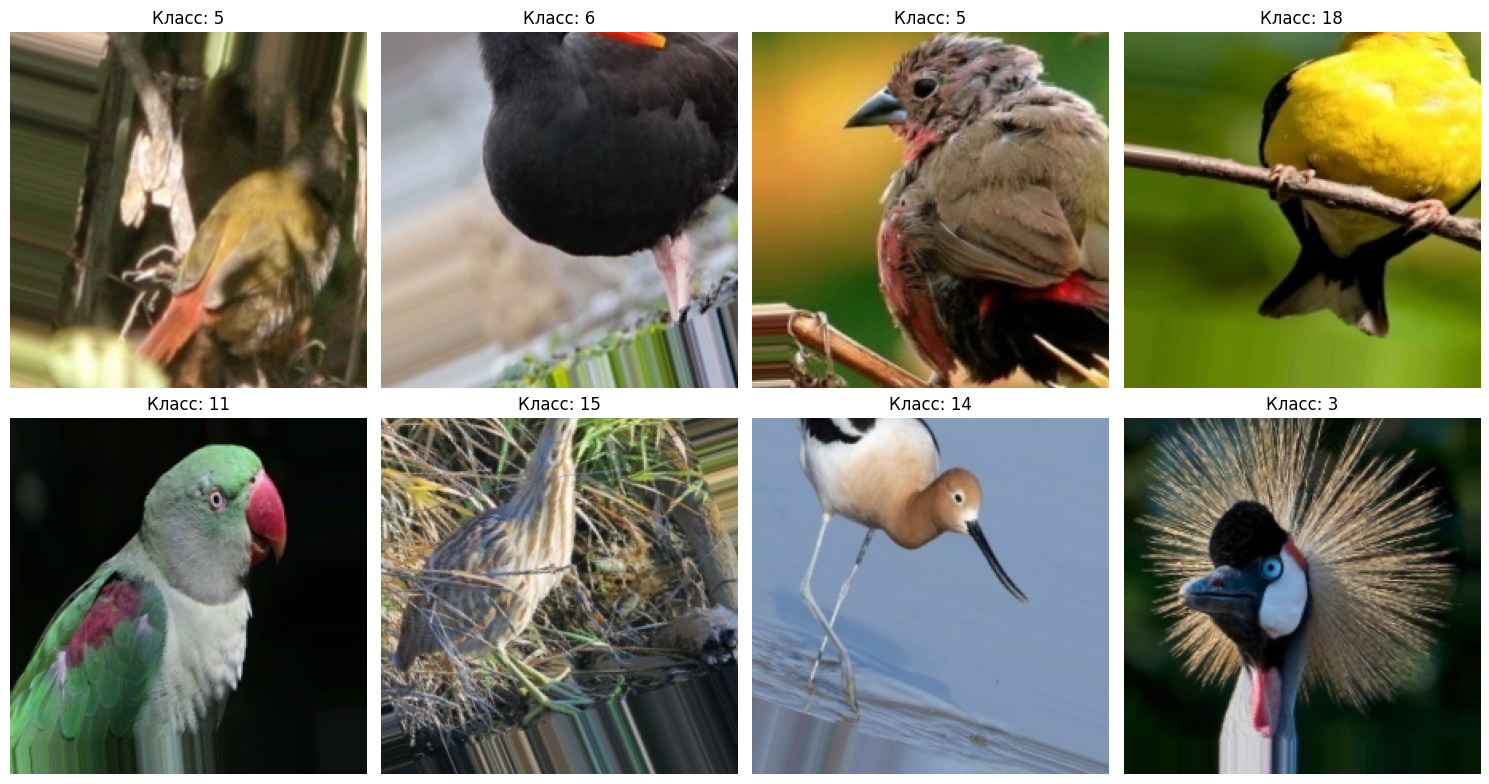

In [8]:
# Функция для проверки данных из генератора
def visualize_batch(generator, batch_size: int = 8) -> None:
    """
    Визуализирует один батч изображений из генератора.

    :param generator: Генератор данных
    :param batch_size: Количество изображений для отображения
    """
    images, labels = next(generator)  # Получаем один батч
    plt.figure(figsize=(15, 8))
    for i in range(batch_size):
        plt.subplot(2, batch_size // 2, i + 1)
        plt.imshow(images[i])
        plt.title(f"Класс: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Визуализация батча из тренировочного генератора
visualize_batch(train_gen)

In [9]:
# Импорт необходимых библиотек для создания модели
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [10]:
# Параметры модели
NUM_CLASSES = len(train_gen.class_indices)  # Количество классов (видов птиц)
LEARNING_RATE = 0.001  # Скорость обучения
EPOCHS = 20  # Количество эпох

# Функция для создания модели
def create_model(input_shape: tuple, num_classes: int) -> Model:
    """
    Создает модель на основе MobileNetV2 с пользовательскими слоями классификации.

    :param input_shape: Форма входных данных (высота, ширина, каналы)
    :param num_classes: Количество классов (выходов модели)
    :return: Компилированная модель
    """
    # Загружаем базовую модель MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Замораживаем слои базовой модели
    base_model.trainable = False

    # Добавляем пользовательские слои
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)  # Dropout для предотвращения переобучения
    x = Dense(128, activation='relu')(x)  # Полносвязный слой
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Выходной слой

    # Создаем и компилируем модель
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Создаем модель
model = create_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)

# Выводим структуру модели
model.summary()

# Настройка коллбеков
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

# Обучение модели
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Загружаем лучшую модель
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,424,532 (9.25 MB)

 Trainable params: 166,548 (650.58 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3686 - loss: 2.2176
Epoch 1: val_accuracy improved from -inf to 0.93000, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 961s 9s/step - accuracy: 0.3704 - loss: 2.2106 - val_accuracy: 0.9300 - val_loss: 0.2860
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8110 - loss: 0.6418
Epoch 2: val_accuracy improved from 0.93000 to 0.94000, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8111 - loss: 0.6413 - val_accuracy: 0.9400 - val_loss: 0.1741
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8476 - loss: 0.4762
Epoch 3: val_accuracy improved from 0.94000 to 0.95000, saving model to best_model.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8476 - loss: 0.4761 - val_accuracy: 0.9500 - val_loss: 0.1215
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8613 - loss: 0.4379
Epoch 4: val_accuracy improved from 0.95000 to 0.9600

In [11]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [19]:
# Функция для оценки модели на тестовом наборе данных
def evaluate_model(model: Model, test_generator) -> None:
    """
    Оценивает модель на тестовом наборе данных.

    :param model: Обученная модель
    :param test_generator: Генератор данных для тестового набора
    """
    print("\nОценка модели на тестовом наборе:")
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Тестовая потеря: {loss:.4f}")
    print(f"Тестовая точность: {accuracy * 100:.2f}%")

# Оценка модели
evaluate_model(model, test_gen)

# Функция для предсказания вида птицы на новом изображении
def predict_species(image_path: str, model: Model, class_indices: dict) -> str:
    """
    Предсказывает вид птицы на основе изображения.

    :param image_path: Путь к изображению
    :param model: Обученная модель
    :param class_indices: Словарь с классами и их индексами
    :return: Название предсказанного вида птицы
    """
    # Загрузка изображения с помощью OpenCV
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")

    # Изменение размера и нормализация изображения
    image_resized = cv2.resize(image, IMAGE_SIZE)
    image_normalized = image_resized / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)  # Добавляем размерность батча

    # Предсказание
    predictions = model.predict(image_batch)
    predicted_class_index = np.argmax(predictions)  # Индекс с наибольшей вероятностью

    # Обратный словарь классов (индексы -> названия)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

# Пример предсказания
test_image_path = '/content/320.jpeg'
try:
    predicted_species = predict_species(test_image_path, model, train_gen.class_indices)
    print(f"Предсказанный вид птицы: {predicted_species}")
except ValueError as e:
    print(str(e))


Оценка модели на тестовом наборе:
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 889ms/step - accuracy: 0.9753 - loss: 0.0594
Тестовая потеря: 0.0503
Тестовая точность: 98.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Предсказанный вид птицы: AFRICAN EMERALD CUCKOO


**Визуализация графиков обучения**

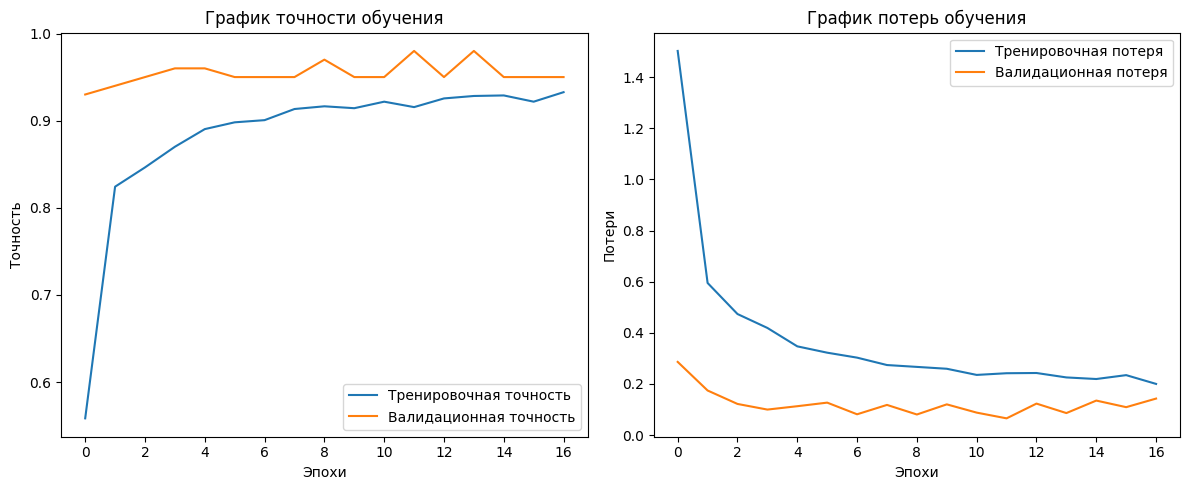

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history) -> None:
    """
    Визуализация графиков обучения модели.

    :param history: Объект History, возвращаемый model.fit()
    """
    # График точности
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Тренировочная точность')
    plt.plot(history.history['val_accuracy'], label='Валидационная точность')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.title('График точности обучения')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Тренировочная потеря')
    plt.plot(history.history['val_loss'], label='Валидационная потеря')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.title('График потерь обучения')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Вызов функции для визуализации
plot_training_history(history)


In [22]:
# Тестирование функции предсказаний
test_images = [
    '/content/320.jpeg',  # Замените на реальный путь к изображению
    '/content/15481362241706.jpg',
    '/content/480.jpeg',
    '/content/80080475.jpg'
]

for image_path in test_images:
    try:
        predicted_species = predict_species(image_path, model, train_gen.class_indices)
        print(f"Изображение: {image_path} -> Предсказанный вид птицы: {predicted_species}")
    except ValueError as e:
        print(f"Ошибка с изображением {image_path}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Изображение: /content/320.jpeg -> Предсказанный вид птицы: AFRICAN EMERALD CUCKOO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Изображение: /content/15481362241706.jpg -> Предсказанный вид птицы: AFRICAN FIREFINCH
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Изображение: /content/480.jpeg -> Предсказанный вид птицы: ALEXANDRINE PARAKEET
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Изображение: /content/80080475.jpg -> Предсказанный вид птицы: AFRICAN PIED HORNBILL
